# HyperSHAP: Example for Optimizer Bias Explanations

In this example, we consider the scenario where we want to explain the tunability of hyperparameters with respect to a baseline configuration and analyze biases of optimizers regarding certain hyperparameters.

## Mockup setup of environment
To this end, we first setup some basic environment, which is assumed to be already existing when working with HyperSHAP. We will setup a configuration space, a baseline configuration and a black box function for which we would like to analyze the tunability of the hyperparameters.

In [6]:
from __future__ import annotations

import math

import numpy as np
from ConfigSpace import Configuration, ConfigurationSpace

# Configuration space with a float, integer, and categorical hyperparameter
cs = ConfigurationSpace(
    name="myspace",
    space={
        "a": (0.1, 1.5),  # UniformFloat
        "b": (0.1, 1.5),  # UniformFloat
        "c": (0.1, 1.5),  # UniformFloat
    },
)


# Some evaluation function that assesses the performance of some configuration
def eval_fun(config: Configuration) -> float:
    return config["a"] + config["b"] + config["c"] + (config["a"] / config["b"])


cs.seed(42)  # set some random seed for reproducibility

# sample some configuration as a baseline
baseline_config = cs.sample_configuration()

print("Baseline", baseline_config, "\nValue", eval_fun(baseline_config))

Baseline Configuration(values={
  'a': 0.6243561663863,
  'b': 0.3183923284707,
  'c': 0.1288182920141,
}) 
Value 3.032531642353654


## HyperSHAP Instantiation with Configuration Space and Surrogate Model

Now it is time to instantiate HyperSHAP. For this, we need to define an explanation task that consists of a configuration space and a surrogate model for predicting the performance of a configuration. `ExplanationTask` comes with a couple of static convenience functions that facilitate the transition from the above configuration space and eval function to an explanation task. For simply building a surrogate model from the specified evaluation function, we can simply call the `from_function()` method and give the resulting explanation task to HyperSHAP.

In [7]:
from hypershap.hypershap import HyperSHAP
from hypershap.task import ExplanationTask

explanation_task = ExplanationTask.from_function(config_space=cs, function=eval_fun, n_samples=50_000)
hypershap = HyperSHAP(explanation_task=explanation_task)

# HyperSHAP Tunability

For a reference, let us first of all analyze the tunability of the above explanation task.

In [8]:
iv = hypershap.tunability(baseline_config=baseline_config, n_samples=50_000)
print(iv)

InteractionValues(
    index=FSII, max_order=2, min_order=0, estimated=False, estimation_budget=None,
    n_players=3, baseline_value=0.0,
    Top 10 interactions:
        (0, 1): 5.228207886813285
        (1,): 4.2430691078178695
        (0,): 3.5176916100305693
        (2,): 1.16078707740834
        (): 0.0
        (0, 2): -0.012690901256074362
        (1, 2): -0.2780457545470619
)


## Plot Shapley Interactions Graph

Now that we have determined the interaction values of the ablation game, let us look into some visualizations of the scenario above.

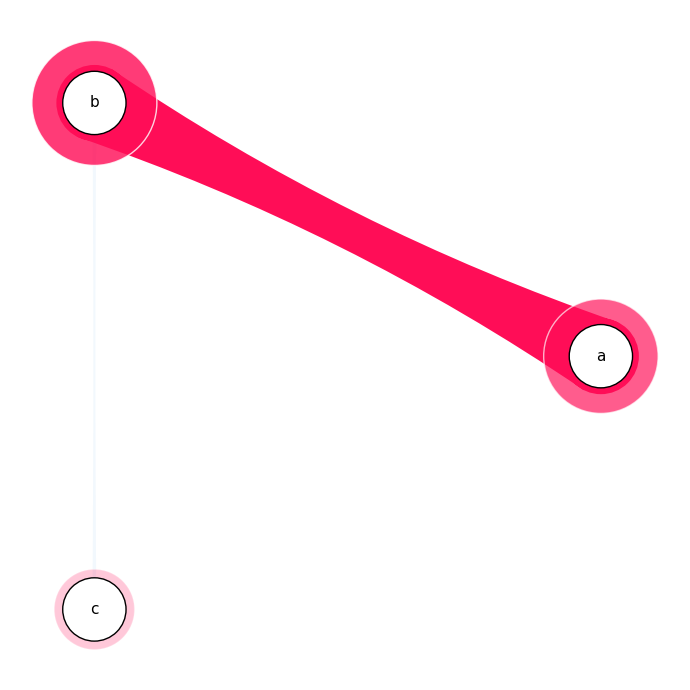

In [9]:
hypershap.plot_si_graph()

**Summary of the above plot**

As expected from the above formula, representing the black-box function, a and b are the most important hyperparameters to be tuned since they exhibit synergetic link.

## Sub-ConfigSpace Searcher

Let us now specify some flawed optimizer which only optimizes a certain subset of hyperparameters.


In [10]:
from hypershap.utils import RandomConfigSpaceSearcher
from hypershap.task import BaselineExplanationTask
import numpy as np


class SubConfigSpaceSearcher(RandomConfigSpaceSearcher):
    def __init__(
        self, explanation_task: BaselineExplanationTask, parameter_activation: list[bool], n_samples: int = 10_000
    ) -> None:
        super().__init__(explanation_task)

        assert len(parameter_activation) == self.explanation_task.get_num_hyperparameters(), (
            "Number of hyperparameters in parameter activation is not equal to explanation_task.get_num_hyperparameters()"
        )

        self.n_samples = n_samples
        self.parameter_activation = np.array(parameter_activation)

    def search(self, coalition: np.ndarray) -> float:
        # copy the sampled configurations
        temp_random_sample = self.random_sample.copy()

        # blind configurations according to coalition and parameter activation map
        activation_map = np.logical_and(self.parameter_activation, coalition)
        blind_coalition = ~activation_map
        column_index = np.where(blind_coalition)
        temp_random_sample[:, column_index] = self.explanation_task.baseline_config.get_array()[column_index]

        vals: np.ndarray = np.array(self.explanation_task.surrogate_model.evaluate(temp_random_sample))
        return vals.max()

## HyperSHAP: Optimizer Bias Game
Now let us have a look at the optimizer bias game, configured in a way that we only tune the second hyperparameter, i.e., the hyperparameter `b`. We compare this optimizer against a full random search, optimizing across all hyperparameters.

In [13]:
bat = BaselineExplanationTask(
    config_space=cs,
    surrogate_model=explanation_task.surrogate_model,
    baseline_config=baseline_config,
)
iv = hypershap.optimizer_bias(
    optimizer_of_interest=SubConfigSpaceSearcher(
        explanation_task=bat, parameter_activation=[False, True, False], n_samples=10_000
    ),
    optimizer_ensemble=[RandomConfigSpaceSearcher(explanation_task=bat, n_samples=50_000)],
)
print(iv)

InteractionValues(
    index=FSII, max_order=2, min_order=0, estimated=False, estimation_budget=None,
    n_players=3, baseline_value=0.0,
    Top 10 interactions:
        (1, 2): 0.35365243459326856
        (0, 2): 0.09899381321631107
        (): 0.0
        (1,): -0.012509774389643602
        (2,): -1.1895547148213383
        (0,): -3.5464592474524803
        (0, 1): -5.126849574489118
)


## Plotting the interaction graph
After we already saw large deficits for the first and third hyperparameter (`a` and `c`) as well as the interaction between `a` and `b`, let us observe these results in the interaction graph.

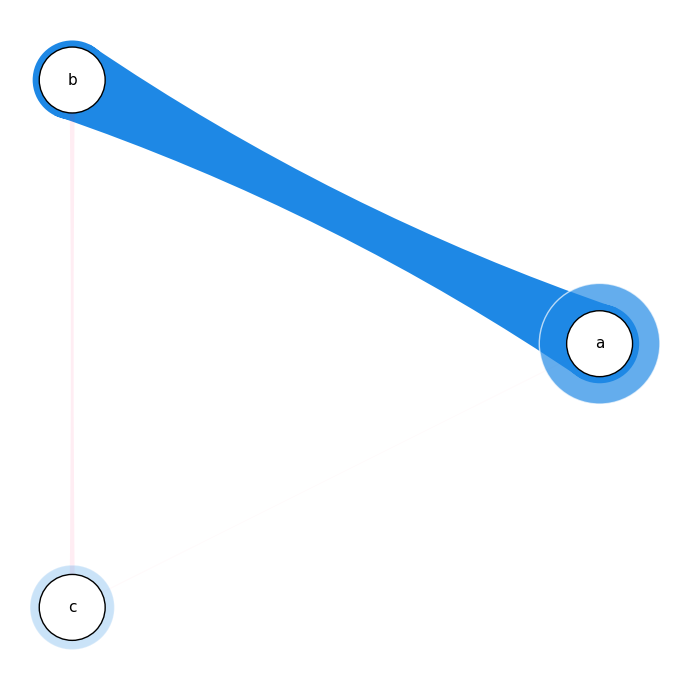

In [14]:
hypershap.plot_si_graph()